In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from tqdm import tqdm
import random
import os

# --- Configuration ---
N_DEVICES = 30
N_FAILING_DEVICES = 9 # Using 9 to get 3 of each failure type
TIME_START = datetime(2023, 1, 1)
TIME_END = datetime(2023, 12, 31)
SAMPLING_INTERVAL_HOURS = 2
OUTPUT_CSV = 'smartwatch_unified_dataset.csv'

# --- Function to generate data for a single device ---
def generate_watch_data(device_id, failure_info):
    """
    Generates a time-series dataset for a single smartwatch with three target labels.
    """
    timestamps = pd.to_datetime(np.arange(TIME_START, TIME_END, timedelta(hours=SAMPLING_INTERVAL_HOURS)))
    n_samples = len(timestamps)
    df = pd.DataFrame({'timestamp': timestamps, 'watch_id': device_id})

    # --- Generate Healthy Features ---
    df['battery_level'] = 100 - (np.sin(np.arange(n_samples) / 12 * np.pi) + 1) * 45 + np.random.normal(0, 2, n_samples)
    df['heart_rate_bpm'] = np.random.normal(70, 15, n_samples) + np.sin(np.arange(n_samples) / 50) * 10
    df['steps_per_hour'] = np.random.poisson(300, n_samples) * (np.sin(np.arange(n_samples) / 12 * np.pi) > 0.5)
    df['gps_active'] = np.random.choice([0, 1], size=n_samples, p=[0.95, 0.05])
    df['screen_on_time_minutes'] = np.random.exponential(5, n_samples)
    df['ambient_temp_c'] = np.random.uniform(15, 35, n_samples) + np.sin(np.arange(n_samples) / (365 * 12) * 2 * np.pi) * 5
    df['water_pressure_atm'] = np.random.normal(1.0, 0.01, n_samples)
    df['fall_detection_events'] = np.random.poisson(0.001, n_samples)

    # --- Initialize Labels ---
    df['failure_type'] = 0 # 0 for Healthy
    df['days_until_failure'] = 999.0
    df['is_failing_soon'] = 0

    if failure_info['is_failing']:
        failure_point = int(n_samples * failure_info['failure_point_ratio'])
        degradation_period = int(n_samples * 0.20)
        degradation_start = failure_point - degradation_period
        degradation_factor = np.linspace(0, 1, n_samples - degradation_start)

        # Apply degradation based on failure type
        if failure_info['failure_type'] == 1: # Battery Failure
            df.loc[degradation_start:, 'battery_level'] *= (1 - degradation_factor * 0.7)
        elif failure_info['failure_type'] == 2: # Heart Rate Sensor Failure
            df.loc[degradation_start:, 'heart_rate_bpm'] += np.random.normal(0, 20, len(degradation_factor)) + 35
        elif failure_info['failure_type'] == 3: # Water Seal Failure
            df.loc[degradation_start:, 'water_pressure_atm'] += np.random.normal(0, 0.2, len(degradation_factor)) + degradation_factor * 0.8

        # --- Generate All Three Labels ---
        for i in range(degradation_start, failure_point):
            days_left = (df.loc[failure_point, 'timestamp'] - df.loc[i, 'timestamp']).total_seconds() / (3600 * 24)
            df.loc[i, 'days_until_failure'] = days_left
            df.loc[i, 'failure_type'] = failure_info['failure_type']
            if days_left <= 7:
                df.loc[i, 'is_failing_soon'] = 1

    # Clip values
    df['battery_level'] = df['battery_level'].clip(0, 100)
    df['heart_rate_bpm'] = df['heart_rate_bpm'].clip(30, 220)
    df['steps_per_hour'] = df['steps_per_hour'].clip(0)

    return df

# --- Main Generation Loop (Memory Optimized) ---
if os.path.exists(OUTPUT_CSV):
    os.remove(OUTPUT_CSV)

all_watch_ids = [f"watch_{i:03d}" for i in range(N_DEVICES)]
failing_watch_ids = random.sample(all_watch_ids, N_FAILING_DEVICES)
failure_types = [1, 2, 3] # 1:Battery, 2:Heart Rate, 3:Water Seal
failure_infos = {}
for i, watch_id in enumerate(failing_watch_ids):
    failure_infos[watch_id] = {
        "is_failing": True,
        "failure_type": failure_types[i % len(failure_types)],
        "failure_point_ratio": random.uniform(0.8, 0.95)
    }

print(f"Generating new unified dataset '{OUTPUT_CSV}'...")
header_written = False
for i in tqdm(range(N_DEVICES), desc="Simulating Watches"):
    device_id = f"watch_{i:03d}"
    info = failure_infos.get(device_id, {"is_failing": False})
    watch_df = generate_watch_data(device_id, info)

    watch_df.to_csv(OUTPUT_CSV, mode='a', header=not header_written, index=False)
    header_written = True

print(f"\n✅ Unified smartwatch dataset generated successfully!")

Generating new unified dataset 'smartwatch_unified_dataset.csv'...


Simulating Watches: 100%|██████████| 30/30 [00:06<00:00,  4.37it/s]


✅ Unified smartwatch dataset generated successfully!


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
from tqdm import tqdm
import os

# --- Configuration ---
INPUT_CSV = 'smartwatch_unified_dataset.csv'
SEQUENCE_DAYS = 14
SAMPLING_INTERVAL_HOURS = 2
TIMESTEPS_PER_DAY = 24 // SAMPLING_INTERVAL_HOURS
SEQUENCE_TIMESTEPS = SEQUENCE_DAYS * TIMESTEPS_PER_DAY

def prepare_smartwatch_large_dataset():
    """
    Prepares the large, unified smartwatch dataset for the multi-task LSTM model.
    """
    print("--- Preparing Large Smartwatch Dataset for Multi-Task Model ---")

    # --- 1. Load Data (Memory Optimized) ---
    print(f"Loading '{INPUT_CSV}'...")
    try:
        dtype_map = {
            'battery_level': 'float32', 'heart_rate_bpm': 'float32',
            'steps_per_hour': 'int16', 'gps_active': 'int8',
            'screen_on_time_minutes': 'float32', 'ambient_temp_c': 'float32',
            'water_pressure_atm': 'float32', 'fall_detection_events': 'int8',
            'failure_type': 'int8', 'days_until_failure': 'float32', 'is_failing_soon': 'int8'
        }
        df = pd.read_csv(INPUT_CSV, dtype=dtype_map, parse_dates=['timestamp'])
    except FileNotFoundError:
        print(f"Error: The file '{INPUT_CSV}' was not found. Please ensure it was generated correctly.")
        return

    df.sort_values(by=['watch_id', 'timestamp'], inplace=True)
    print("Data loaded successfully.")

    # --- 2. Scale Features ---
    feature_columns = [
        'battery_level', 'heart_rate_bpm', 'steps_per_hour', 'gps_active',
        'screen_on_time_minutes', 'ambient_temp_c', 'water_pressure_atm',
        'fall_detection_events'
    ]

    print("\nScaling features...")
    scaler = MinMaxScaler()
    df[feature_columns] = scaler.fit_transform(df[feature_columns])
    joblib.dump(scaler, 'smartwatch_multi_task_scaler.joblib')
    print("Scaler saved to 'smartwatch_multi_task_scaler.joblib'.")

    # --- 3. Create Sequences ---
    print(f"\nCreating sequences of {SEQUENCE_TIMESTEPS} timesteps...")
    sequences, labels_why, labels_when, labels_if = [], [], [], []

    grouped_data = df.groupby('watch_id')

    for _, group in tqdm(grouped_data, desc="Creating Sequences"):
        features = group[feature_columns].values
        label_why = group['failure_type'].values
        label_when = group['days_until_failure'].values
        label_if = group['is_failing_soon'].values

        for i in range(len(features) - SEQUENCE_TIMESTEPS):
            sequences.append(features[i:i + SEQUENCE_TIMESTEPS])
            labels_why.append(label_why[i + SEQUENCE_TIMESTEPS - 1])
            labels_when.append(label_when[i + SEQUENCE_TIMESTEPS - 1])
            labels_if.append(label_if[i + SEQUENCE_TIMESTEPS - 1])

    X = np.array(sequences)
    y_why = np.array(labels_why)
    y_when = np.array(labels_when)
    y_if = np.array(labels_if)

    # --- 4. Save Processed Data ---
    print("\nSaving processed data to .npy files...")
    np.save('smartwatch_sequences_large.npy', X)
    np.save('smartwatch_labels_why_large.npy', y_why)
    np.save('smartwatch_labels_when_large.npy', y_when)
    np.save('smartwatch_labels_if_large.npy', y_if)

    print("\n✅ Data preparation complete. You are now ready to train the multi-task model for the smartwatches.")

if __name__ == "__main__":
    prepare_smartwatch_large_dataset()

--- Preparing Large Smartwatch Dataset for Multi-Task Model ---
Loading 'smartwatch_unified_dataset.csv'...
Data loaded successfully.

Scaling features...
Scaler saved to 'smartwatch_multi_task_scaler.joblib'.

Creating sequences of 168 timesteps...


Creating Sequences: 100%|██████████| 30/30 [00:00<00:00, 150.86it/s]



Saving processed data to .npy files...

✅ Data preparation complete. You are now ready to train the multi-task model for the smartwatches.


--- Loading Prepared Sequence Data ---
Data loaded successfully. X shape: (126000, 168, 8), y shape: (126000,)
--- Reshaping Data for LightGBM ---
Reshaped X to: (126000, 1344)
--- Splitting Data ---
--- Calculating Class Weights for LightGBM ---
Scale Pos Weight: 165.61

--- Building and Training LightGBM Model ---
[LightGBM] [Info] Number of positive: 605, number of negative: 100195
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 5.059054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 235712
[LightGBM] [Info] Number of data points in the train set: 100800, number of used features: 1344
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006002 -> initscore=-5.109645
[LightGBM] [Info] Start training from score -5.109645
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[324]	valid_0's binary_logloss: 0.0307067

--- Evaluating Model Performance ---

Classif

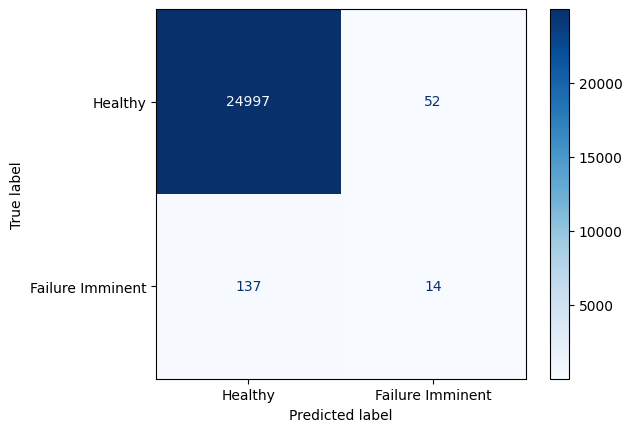


✅ Training complete. Final LightGBM model saved to 'prediction_model_lgbm_if.joblib'.


In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import warnings
import os

warnings.filterwarnings("ignore")

# --- 1. Load Data ---
print("--- Loading Prepared Sequence Data ---")
X_FILE = 'smartwatch_sequences_large.npy'
Y_FILE = 'smartwatch_labels_if_large.npy'

try:
    X = np.load(X_FILE)
    y = np.load(Y_FILE)
    print(f"Data loaded successfully. X shape: {X.shape}, y shape: {y.shape}")
except FileNotFoundError:
    print(f"Error: Make sure '{X_FILE}' and '{Y_FILE}' exist.")
    exit()

# --- 2. Reshape Data for LightGBM ---
# LightGBM expects a 2D array (samples, features), so we flatten the sequences.
print("--- Reshaping Data for LightGBM ---")
n_samples = X.shape[0]
n_timesteps = X.shape[1]
n_features = X.shape[2]
X_reshaped = X.reshape(n_samples, n_timesteps * n_features)
print(f"Reshaped X to: {X_reshaped.shape}")

# --- 3. Split Data ---
print("--- Splitting Data ---")
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=42, stratify=y
)

# --- 4. Handle Class Imbalance ---
# LightGBM has a built-in parameter for this, which is more stable.
print("--- Calculating Class Weights for LightGBM ---")
count_healthy = np.sum(y_train == 0)
count_failing = np.sum(y_train == 1)
scale_pos_weight = count_healthy / count_failing
print(f"Scale Pos Weight: {scale_pos_weight:.2f}")

# --- 5. Build and Train the LightGBM Model ---
print("\n--- Building and Training LightGBM Model ---")
lgbm = lgb.LGBMClassifier(
    objective='binary',
    n_estimators=1000, # Train a good number of trees
    learning_rate=0.05,
    num_leaves=31,
    scale_pos_weight=scale_pos_weight, # Handle imbalance
    random_state=42,
    n_jobs=-1
)

# Train the model with early stopping
lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='logloss',
    callbacks=[lgb.early_stopping(10)] # Stop if performance doesn't improve for 10 rounds
)

# --- 6. Evaluate the Model ---
print("\n--- Evaluating Model Performance ---")
y_pred = lgbm.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Healthy', 'Failure Imminent']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Failure Imminent'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# --- 7. Save the Final Model ---
MODEL_FILENAME = 'prediction_model_lgbm_if.joblib'
joblib.dump(lgbm, MODEL_FILENAME)
print(f"\n✅ Training complete. Final LightGBM model saved to '{MODEL_FILENAME}'.")

--- Loading data and trained LightGBM model for smartwatches ---
--- Getting raw prediction scores from the model ---
--- Plotting the Precision-Recall Trade-off Curve ---


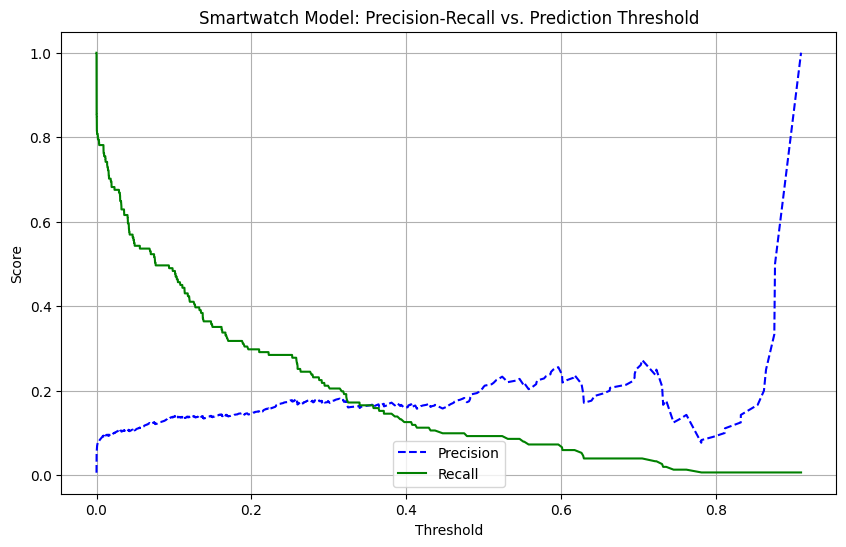


--- Finding and Applying a Better Threshold ---
Original Report (Threshold = 0.50):
                  precision    recall  f1-score   support

         Healthy       0.99      1.00      1.00     25049
Failure Imminent       0.21      0.09      0.13       151

        accuracy                           0.99     25200
       macro avg       0.60      0.55      0.56     25200
    weighted avg       0.99      0.99      0.99     25200

A better threshold might be: 0.0183
This threshold aims for at least 70% Recall while maximizing Precision.

New Report using Tuned Threshold (0.0183):
                  precision    recall  f1-score   support

         Healthy       1.00      0.96      0.98     25049
Failure Imminent       0.10      0.70      0.17       151

        accuracy                           0.96     25200
       macro avg       0.55      0.83      0.57     25200
    weighted avg       0.99      0.96      0.97     25200



In [3]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, classification_report
import matplotlib.pyplot as plt
import joblib

# --- 1. Load Data and Model ---
print("--- Loading data and trained LightGBM model for smartwatches ---")
try:
    X = np.load('smartwatch_sequences_large.npy')
    y = np.load('smartwatch_labels_if_large.npy')
    model = joblib.load('/content/prediction_model_lgbm_if.joblib')
except FileNotFoundError:
    print("Error: Make sure all necessary files are available.")
    exit()

# Reshape data for the model
n_samples, n_timesteps, n_features = X.shape
X_reshaped = X.reshape(n_samples, n_timesteps * n_features)

# Recreate the exact test set
_, X_test, _, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=42, stratify=y
)

# --- 2. Get Prediction Probabilities ---
print("--- Getting raw prediction scores from the model ---")
y_scores = model.predict_proba(X_test)[:, 1]

# --- 3. Plot the Precision-Recall Curve ---
print("--- Plotting the Precision-Recall Trade-off Curve ---")
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.title('Smartwatch Model: Precision-Recall vs. Prediction Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# --- 4. Find and Apply a Better Threshold ---
print("\n--- Finding and Applying a Better Threshold ---")

# Let's find a threshold that gives us at least 70% recall
try:
    high_recall_indices = np.where(recall[:-1] >= 0.70)[0]
    best_threshold_idx = high_recall_indices[np.argmax(precision[high_recall_indices])]
    best_threshold = thresholds[best_threshold_idx]

    print(f"Original Report (Threshold = 0.50):")
    y_pred_default = (y_scores > 0.5).astype("int32")
    print(classification_report(y_test, y_pred_default, target_names=['Healthy', 'Failure Imminent']))

    print("="*60)
    print(f"A better threshold might be: {best_threshold:.4f}")
    print(f"This threshold aims for at least 70% Recall while maximizing Precision.")
    print(f"\nNew Report using Tuned Threshold ({best_threshold:.4f}):")
    y_pred_tuned = (y_scores > best_threshold).astype("int32")
    print(classification_report(y_test, y_pred_tuned, target_names=['Healthy', 'Failure Imminent']))

except (ValueError, IndexError):
    print("\nCould not automatically find a threshold for 70% recall. Please inspect the plot manually to choose one.")

In [4]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error
import joblib

# --- 1. Load Data ---
print("--- Loading Data for Smartwatch Diagnostician ---")
try:
    X = np.load('smartwatch_sequences_large.npy')
    y_why = np.load('smartwatch_labels_why_large.npy')
    y_when = np.load('smartwatch_labels_when_large.npy')
except FileNotFoundError:
    print("Error: Make sure all 'smartwatch_..._large.npy' files are available.")
    exit()

# --- 2. Isolate ONLY the Failing Data ---
print("--- Isolating Data for Failing Devices Only ---")
failure_indices = np.where(y_why != 0)[0]

X_failing = X[failure_indices]
y_why_failing = y_why[failure_indices]
y_when_failing = y_when[failure_indices]

print(f"Isolated {len(X_failing)} sequences from failing devices.")

# --- 3. Reshape Data for LightGBM ---
n_samples, n_timesteps, n_features = X_failing.shape
X_reshaped = X_failing.reshape(n_samples, n_timesteps * n_features)

# --- 4. Split Data ---
X_train, X_test, y_train_why, y_test_why, y_train_when, y_test_when = train_test_split(
    X_reshaped, y_why_failing, y_when_failing, test_size=0.2, random_state=42
)

# --- 5. Train the "WHY" (Classifier) Model ---
print("\n--- Training the 'WHY' (Classifier) Model ---")
# Define human-readable names for failure types
failure_map = {1: "Battery Failure", 2: "Heart Rate Sensor Failure", 3: "Water Seal Failure"}

lgbm_why = lgb.LGBMClassifier(objective='multiclass', random_state=42)
lgbm_why.fit(X_train, y_train_why)

# --- 6. Train the "WHEN" (Regressor) Model ---
print("\n--- Training the 'WHEN' (Regressor) Model ---")
lgbm_when = lgb.LGBMRegressor(objective='regression_l1', random_state=42)
lgbm_when.fit(X_train, y_train_when)

# --- 7. Evaluate the Models ---
print("\n--- Evaluating Diagnostician Models ---")

# Evaluate "WHY" model
y_pred_why = lgbm_why.predict(X_test)
print("\n'WHY' Model Classification Report:")
print(classification_report(y_test_why, y_pred_why, target_names=failure_map.values()))

# Evaluate "WHEN" model
y_pred_when = lgbm_when.predict(X_test)
mae = mean_absolute_error(y_test_when, y_pred_when)
print(f"\n'WHEN' Model Mean Absolute Error: {mae:.2f} days")
print("(This means on average, the prediction for days-to-failure is off by this amount)")

# --- 8. Save the Final Models ---
joblib.dump(lgbm_why, 'smartwatch_diagnostician_why.joblib')
joblib.dump(lgbm_when, 'smartwatch_diagnostician_when.joblib')
print("\n✅ Training complete. Final diagnostician models for the smartwatch have been saved.")


--- Loading Data for Smartwatch Diagnostician ---
--- Isolating Data for Failing Devices Only ---
Isolated 7857 sequences from failing devices.

--- Training the 'WHY' (Classifier) Model ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229851
[LightGBM] [Info] Number of data points in the train set: 6285, number of used features: 1176
[LightGBM] [Info] Start training from score -1.100045
[LightGBM] [Info] Start training from score -1.085336
[LightGBM] [Info] Start training from score -1.110617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga